In [227]:
import json
import uuid
from functools import reduce, wraps

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, HTML, FileLink

from jinja2 import Template

# Smartsheet
import sys
from collections import defaultdict, namedtuple
import smartsheet

# Define a quartely time schema
years_in_model = 3
quarters = list(range(1, years_in_model * 4 + 1))  # list bc we don't want this to be a generator
quarters_index = list(range(years_in_model * 4))
quarter_labels = ['Q' + str(q) for q in quarters]

# Portfolio Cash Flow Analysis

In [228]:
class CashFlow():
    def __init__(self, delay_qtrs, discount_rate, is_cost, max_amt, scale_up_qtrs,
                 function, name='', discounted=True, flow_id=uuid.uuid4(), tot_qtrs=12):
        if scale_up_qtrs < 2: 
            raise Exception('the total number of quarters must be at least one')

        self.delay_qtrs = delay_qtrs
        self.discounted = discounted
        self.discount_rate = discount_rate / 4 # annual discount rate -> quarterly
        self.function = function # Will interpret an instance according to this setting
        self.id = flow_id
        self.is_cost = is_cost
        self.max_amt = max_amt
        self.name = name
        self.scale_up_qtrs = scale_up_qtrs
        self.tot_qtrs = tot_qtrs  # TODO: rename to "period"
        
    def _sigmoid(self, x):
        """
        We define y at 95% max at end of delay and scale up period 
        y = .95L = L / (1 + e^-k(x_end - x_naught)) # https://en.wikipedia.org/wiki/Logistic_function
        For us, this means the scaling factor (k) is
        k = ln(1/.95 - 1)/((delay_qtrs + scale_up_qtrs/2) - (delay_qtrs + scale_up_qtrs))
        """
        # 1 / 2 scale_up_qtrs to place x_naught at vertical of sigmoid from after delay
        x_naught = self.delay_qtrs + self.scale_up_qtrs / 2
        x_end = self.delay_qtrs + self.scale_up_qtrs
        k = math.log(1/.95 - 1) / (x_naught - x_end)
        return self.max_amt / (1 + math.exp(-k * (x - x_naught)))
    
    def _linear(self, x):
        """y = mx + b. Units in amount (returned value) per quarter (x)"""
        m = self.max_amt / self.scale_up_qtrs
        b = -m * self.delay_qtrs
        return min(m * x + b, self.max_amt) # Never return more than max
    
    def _single(self, x):
        if x == self.delay_qtrs:
            return self.max_amt
        else:
            return 0
    
    def _step(self, x):
        return self.max_amt
 
    def _discounted_cash_flow(self, f):
        @wraps(f)
        def discounted_wrapper(quarter_n):
            return f(quarter_n) / (1 + self.discount_rate) ** quarter_n

        return discounted_wrapper
    
    def _calculate_qtr(self, f):
        values = []
        discounted_f = self._discounted_cash_flow(f) if self.discounted else f
        for quarter_n in range(0, self.tot_qtrs):
            if quarter_n < self.delay_qtrs:
                values.append(0)
            else:
                multiplier = -1 if self.is_cost else 1
                # TODO: multiply by -1 here if it is a COST we are considering
                values.append(multiplier * discounted_f(quarter_n))
        return values

    def quick_view(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(range(self.tot_qtrs), self.sigmoid_qtr, label='sigmoid')
        ax.plot(range(self.tot_qtrs), self.linear_qtr, label='linear')
        ax.plot(range(self.tot_qtrs), self.step_qtr, label='step')
        ax.scatter(range(self.tot_qtrs), self.single_qtr, label='single')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    @property
    def qtr(self):
        """calculates quarter for instance based on set function type"""
        return self._calculate_qtr(getattr(self, f'_{self.function.lower()}'))
    
    @property
    def sigmoid_qtr(self):
        return self._calculate_qtr(self._sigmoid)
    
    @property
    def linear_qtr(self):
        return self._calculate_qtr(self._linear)
    
    @property
    def step_qtr(self):
        return self._calculate_qtr(self._step)
    
    @property
    def single_qtr(self):
        return self._calculate_qtr(self._single)
    
    def to_json(self):
        return {
            "delay_qtrs": self.delay_qtrs,
            "discount_rate": self.discount_rate,
            "flow_id": str(self.id),
            "function": self.function,
            "is_cost": self.is_cost,
            "name": self.name,
            "max_amt": self.max_amt,
            "scale_up_qtrs": self.scale_up_qtrs,
            "tot_qtrs": self.tot_qtrs,
        }

In [229]:
class Styles():
    CONTAINER = "padding: 0; display: flex;"
    PARAM = "flex: 1; list-style-type: none; text-align: center;"
    VALUE = "display: block; text-align: center;"
    
class Project():
    """Add cash flows to a project"""
    def __init__(self, name, cash_flows=None):
        self.name = name
        self.cash_flows = cash_flows
        # Generate Graph portion
        self.graph_out = widgets.Output()
        self.update_graphs()
        # Generate Table portion
        self.table_out = widgets.Output()
        self.update_table()
        self.app = widgets.VBox(children=[self.graph_out, self.table_out], layout=widgets.Layout(overflow="hidden"))
        display(self.app)
    
    def to_df(self):
        df = pd.DataFrame(map(lambda cf: cf.to_json(), self.cash_flows)).drop(['flow_id'], axis=1)
        return df.set_index('name')
    
    def set_discounted_for_cash_flows(self, b):
        for cash_flow in self.cash_flows:
            cash_flow.discounted = b
        
    def update_table(self):
        self.table_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return
        
        table = self.to_df()
        with self.table_out:
            display(table)
        
    def update_graphs(self):
        self.graph_out.clear_output(wait=True)
        if len(self.cash_flows) == 0:
            return

        def trim_axs(axs, N):
            axs = axs.flat
            for ax in axs[N:]:
                ax.remove()
            return axs[:N]

        # TODO: remove this if we decide to keep the other funciton "get_max"
        def get_min_max(flows):
            values = reduce(list.__add__, [flow.qtr for flow in flows])
            minimum = min(0, min(values))
            maximum = max(values)
            return minimum + minimum * 0.2, maximum + maximum * 0.2  # + 20% padding for readability
        
        def get_max(flows):
            values = reduce(list.__add__, [list(map(lambda v: abs(v), flow.qtr)) for flow in flows])
            maximum = max(values)
            return -1 * maximum, maximum
        
        # capture stdout of matplotlib to output catching context graph_out as widget to include
        with self.graph_out:
            cols = 4
            rows = len(self.cash_flows) // cols + 1
            figsize = (12, rows * 3)
            fig, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
            axs = trim_axs(axs, len(self.cash_flows))
            ymin, ymax = get_max(self.cash_flows)  # or get_min_max
            for ax, cf in zip(axs, self.cash_flows):
                ax.set_title(cf.name)
                ax.set_ylim([ymin,ymax])
                ax.grid(True)
                ax.xaxis.set_ticks(range(1, 13))
                ax.axhline(y=0, color='black', linestyle='--')
                ax.plot(range(12), cf.qtr)

            plt.show(fig)


In [230]:
# Simple named tuple to organize the index of a cell, and if it is required or not
#
# Parsing immediately, and with intent of what must be there prevents
# a slew of boundary type errors or runtime ones.
Cell = namedtuple('Cell', ['index', 'name', 'required'])


class SmartsheetRow():
    """Reusable Smartsheet class for parsing a row. To use, define a child class which contains
    class attributes with a namedtuple defining each cell that should be parsed. This child class will
    inherit from this one, and automatically load and process all defined attributes.
    It is also possible to define methods to override the value when necessary. For example, divide an
    annual value by four"""
    def __init__(self, row):
        self.sheet_row = row
        self.cells = row['cells']
        self.row_number = row['rowNumber']
        # essentially grab the class attributes
        self.cell_defs = [getattr(self, attr) for attr in dir(self) if 'CELL_' in attr]
        self._load_cells()

    def _load_cells(self):
        for cell_def in self.cell_defs:
            modifier = getattr(self, f'_{cell_def.name}', None) or self._identity
            unmodified = self._get_cell(cell_def)
            value = modifier(unmodified) if unmodified is not None else None
            setattr(self, cell_def.name, value)
        
    @staticmethod
    def _identity(x):
        return x
        
    def _get_cell(self, cell_descriptor):
        """Will try to grab the cell regardless, if it is required, an error will be logged"""
        try:
            if cell_descriptor.required:
                cell_value = self.cells[cell_descriptor.index]['value']
                return cell_value
            else:
                cell = self.cells[cell_descriptor.index]
                return cell.get('value', None)
        except:
            raise Exception(f'Failed to process Row <{self.row_number}>. Missing {cell_descriptor.name}')

    def to_json(self):
        cell_defs = [getattr(self, attr) for attr in dir(self) if 'CELL_' in attr]
        return { cd.name: getattr(self, cd.name) for cd in cell_defs}


class PortfolioSheetRow(SmartsheetRow):
    """All cells that are desired MUST have a class attribute defined where:
       "CELL_" is part of the name. The class will use those attributes to parse the row.
       
       Any methods defined with the same "name" as the attribute preceeded by an underscore
       will apploy that function to the attribute as a clean way to modify the value if necessary.
       """
    CELL_00 = Cell(0, 'name', True)
    CELL_01 = Cell(1, 'fte', False)
    CELL_02 = Cell(2, 'fte_unallocated', False)
    CELL_03 = Cell(3, 'fte_other', False)
    CELL_04 = Cell(4, 'include_in_model', True)
    CELL_05 = Cell(5, 'project_code', True)
    CELL_06 = Cell(6, 'annual_revenue', False)
    CELL_07 = Cell(7, 'gross_profit_perc', False)
    CELL_08 = Cell(8, 'attribution_perc', False)
    CELL_09 = Cell(9, 'is_cost', True)
    CELL_10 = Cell(10, 'function', True)
    CELL_11 = Cell(11, 'discount_rate', True)
    CELL_12 = Cell(12, 'start_value', False)
    CELL_13 = Cell(13, 'delay_qtrs', True)
    CELL_14 = Cell(14, 'max_amt', True)
    CELL_15 = Cell(15, 'scale_up_qtrs', True)
    CELL_16 = Cell(16, 'comments', False)
    
    def __init__(self, row):
        # Extra logic is used to decide if row should be processed at all
        # This allows us to "fail fast" when a row we want to parse doesn't have the data we want
        cells = row['cells']
        include = cells[PortfolioSheetRow.CELL_04.index].get('value', None)
        self.project_code = cells[PortfolioSheetRow.CELL_05.index].get('value', None)
        self.include_in_model = True if include == "Yes" else False
        
        if self.include_in_model and self.project_code:
            super().__init__(row)
        
    @staticmethod
    def _function(val):
        text = val.strip().lower()
        if text == 'continuous' or text == 'step':
            return 'step'
        elif text == 'single pmt.':
            return 'single'
        elif text == 'logistic':
            return 'sigmoid'
        elif text == 'linear':
            return 'linear'
        else:
            raise Exception(f'Unknown profile type: {val}')
    
    @staticmethod
    def _include_in_model(val):
        return val.lower() == 'yes'

    @staticmethod
    def _is_cost(val):
        return val.lower() == 'cost'

In [231]:
access_token = 'u1zwu2cf2708fdfuy6y46ttwx3'
sheet_id = 3317327430215556
ss = smartsheet.Smartsheet(access_token)
sheet = ss.Sheets.get_sheet(sheet_id)

# # Script for quick verification testing
# row_num = 47
# row = sheet.rows[row_num - 1]
# r = PortfolioSheetRow(row.to_dict())
# blacklisted = ['__', 'cell_defs', 'CELL', 'cells', 'sheet_row', '_get_cell', '_identity', '_profile_type', 'row_number', '_include']
# for a in dir(r):
#     if any([s in a for s in blacklisted]):
#         continue
#     print(a + '\t\t\t' + str(getattr(r, a)))

In [232]:
# Allow for easy targeting of rows, here [20 - 70]
SHEET_ROW_START = 20
SHEET_ROW_END = 70

def sheet_row_to_cf(row):
    return CashFlow(
        delay_qtrs = row.delay_qtrs,
        discounted = True,
        discount_rate = row.discount_rate,
        max_amt = row.max_amt,
        scale_up_qtrs = row.scale_up_qtrs,
        function = row.function,
        name = row.name,
        is_cost = row.is_cost
    )

# iterate through smartsheet and build project map
project_map = defaultdict(list)
for index, sheet_row in enumerate(sheet.rows):
    if index < SHEET_ROW_START or index > SHEET_ROW_END:
        continue

    row = PortfolioSheetRow(sheet_row.to_dict())
    if row.project_code and row.include_in_model:
        project_map[row.project_code].append(sheet_row_to_cf(row))

# Build DataFrame from project_map
rows = []
for project_id, cash_flows in project_map.items():
    for cash_flow in cash_flows:
        # Discounted
        assert cash_flow.discounted
        rows.append([project_id, True, cash_flow.name] + cash_flow.qtr)
        # Undiscounted
        cash_flow.discounted = False
        rows.append([project_id, False, cash_flow.name] + cash_flow.qtr)
        cash_flow.discounted = True # set it back (default)
        
df = pd.DataFrame(data=rows, columns=['project', 'discounted', 'name'] + quarter_labels)
df.groupby(['project', 'discounted']).sum(numeric_only=True).sum(numeric_only=True, axis=1).reset_index(name='NPV')

,project,discounted,NPV
0,BP,False,-4.678182
1,BP,True,-4.746166
2,FS,False,13.426765
3,FS,True,7.301263
4,PV,False,12.386509
5,PV,True,3.458543


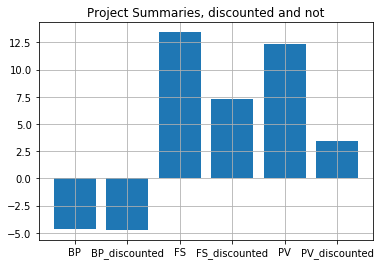

In [233]:
def gen_label(row):
    postfix = '_discounted' if row['discounted'] else ''
    return row['project'] + postfix

table = df.groupby(['project', 'discounted']).sum(numeric_only=True).sum(numeric_only=True, axis=1).reset_index(name='NPV')
table['label'] = table.apply(gen_label, axis=1)
table

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(table['label'], table['NPV'])
ax.set_title('Project Summaries, discounted and not')
ax.grid(True)

In [234]:
def display_dataframe(df, title):
    display(HTML(f'<div><h3>{title}</h3></div>'))
    df.loc["Total"] = df.sum(numeric_only=True)
    cleaned = df.drop(['project', 'discounted'], axis=1)
    display(cleaned)

    
for project_id in df['project'].unique():
    display(HTML(f'<div><h1>{project_id}</h1><hr /></div>'))
    ndf = df[df['project'] == project_id].set_index('name')
    display_dataframe(ndf[ndf['discounted']].copy(), "Discounted Cash Flows")
    display_dataframe(ndf[ndf['discounted'] == False].copy(), "Undiscounted Cash Flows")

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,-0.3125,-0.304878,-0.297442,-0.290187,-0.283110,-0.276204,-0.269468,-0.262895,-0.256483,-0.250228,-0.244125,-0.238170
Pipeline FS Product Credits,-0.1800,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
Pipeline FS - Stockton,0.0000,0.000000,0.000000,0.000000,0.122942,0.111766,0.101605,0.092368,0.083971,0.076338,0.069398,0.063089
Pipeline FS - Magic Valley,0.0000,0.000000,0.136106,0.118353,0.102916,0.089492,0.077819,0.067669,0.058842,0.051167,0.044493,0.038690
Projected Whitespace Wins,0.0000,0.000000,0.000000,0.129576,0.244355,0.438631,0.724998,1.066022,1.372924,1.572964,1.659398,1.666336
Projected Margin Accretion,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012536,0.023641,0.042437,0.070143,0.103137,0.132830
Total,-0.4925,-0.304878,-0.161336,-0.042259,0.187103,0.363684,0.647491,0.986805,1.301692,1.520385,1.632302,1.662775


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Frontsight Program Costs,-0.3125,-0.3125,-0.3125,-0.3125,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500,-0.312500
Pipeline FS Product Credits,-0.1800,0.0000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Pipeline FS - Stockton,0.0000,0.0000,0.0000,0.0000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Pipeline FS - Magic Valley,0.0000,0.0000,0.1800,0.1800,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000,0.180000
Projected Whitespace Wins,0.0000,0.0000,0.0000,0.1500,0.297015,0.559816,0.971566,1.500000,2.028434,2.440184,2.702985,2.850000
Projected Margin Accretion,0.0000,0.0000,0.0000,0.0000,0.000000,0.000000,0.016800,0.033266,0.062699,0.108815,0.168000,0.227185
Total,-0.4925,-0.3125,-0.1325,0.0175,0.344515,0.607316,1.035866,1.580766,2.138633,2.596499,2.918485,3.124685


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,-0.000000,-0.048780,-0.095181,-0.139290,-0.181190,-0.220964,-0.258689,-0.294443,-0.328299,-0.360328,-0.390599,-0.419180
Internal Headcount,-0.593182,-0.578714,-0.564599,-0.550828,-0.537393,-0.524286,-0.511499,-0.499023,-0.486852,-0.474978,-0.463393,-0.452090
Revenue Defense - Showme,0.200000,0.192771,0.185803,0.179088,0.172615,0.166376,0.160362,0.154566,0.148979,0.143594,0.138404,0.133402
United Ethanol Whitespace Win,0.120000,0.115663,0.111482,0.107453,0.103569,0.099825,0.096217,0.092739,0.089387,0.086157,0.083042,0.080041
Guardian - Hankinson Defense,0.000000,0.000000,0.000000,0.000000,0.000000,0.147702,0.139013,0.130836,0.123140,0.115896,0.109079,0.102662
Valero - Net new,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033932
Madeira - Fleet Trials,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057948,0.054539,0.051331
Total,-0.273182,-0.319061,-0.362495,-0.403578,-0.442400,-0.331347,-0.374595,-0.415325,-0.453644,-0.431710,-0.468927,-0.469902


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
External Investment,-0.000000,-0.050000,-0.100000,-0.150000,-0.200000,-0.250000,-0.300000,-0.350000,-0.400000,-0.450000,-0.500000,-0.550000
Internal Headcount,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182,-0.593182
Revenue Defense - Showme,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
United Ethanol Whitespace Win,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000,0.120000
Guardian - Hankinson Defense,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000,0.200000
Valero - Net new,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000
Madeira - Fleet Trials,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000,0.100000
Total,-0.273182,-0.323182,-0.373182,-0.423182,-0.473182,-0.323182,-0.373182,-0.423182,-0.473182,-0.423182,-0.473182,-0.323182


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-0.444886,-0.434035,-0.423449,-0.413121,-0.403045,-0.393215,-0.383624,-0.374267,-0.365139,-0.356233,-0.347545,-0.339068
Benefits - Contracted GPRE,0.375000,0.352941,0.332180,0.312640,0.294249,0.276941,0.260650,0.245318,0.230887,0.217306,0.204523,0.192492
Benefits - Potential GPRE,0.000000,0.000000,0.000000,0.158025,0.222410,0.307521,0.414211,0.537858,0.665971,0.779489,0.859559,0.896002
Total,-0.069886,-0.081094,-0.091269,0.057543,0.113614,0.191246,0.291237,0.408909,0.531719,0.640561,0.716537,0.749427


,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11,Q12
name,,,,,,,,,,,,
Internal Headcount,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886,-0.444886
Benefits - Contracted GPRE,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000,0.375000
Benefits - Potential GPRE,0.000000,0.000000,0.000000,0.225000,0.356258,0.554162,0.839725,1.226692,1.708737,2.250000,2.791263,3.273308
Total,-0.069886,-0.069886,-0.069886,0.155114,0.286372,0.484276,0.769838,1.156806,1.638850,2.180114,2.721377,3.203421


In [235]:
# Build UI from project_map
projects = []
for project_id, cash_flows in project_map.items():
    display(HTML(f'<div><h1>{project_id}</h1><br /><hr /></div>'))
    projects.append(Project(project_id, cash_flows))

In [236]:
graph_out = widgets.Output()

def combine_flows(flows):
    qtr_values = map(lambda cf: cf.qtr, flows)
    aggregated_values = [sum(values) for values in zip(*qtr_values)]
    return aggregated_values

def get_x_ticks(index, bar_width, step=1):
    return [x - (bar_width * len(projects)) + (bar_width * index) for x in range(12)]

def plot_projects_summary():
    projects_values = map(lambda p: combine_flows(p.cash_flows), projects)
    projects_net = [sum(values) for values in zip(*projects_values)]

    figsize = (25, 8)
    plt.figure(figsize=figsize)
    plt.xticks(range(0, 12))
    bar_room = .75 # 75% of space will have a bar plotted on it
    bar_width = bar_room * 1 / (len(projects) + 1)  # + 1 in denominator to account for 'net'
    legend_parents = []
    for i, project in enumerate(projects):
        xseries = get_x_ticks(i, bar_width)
        plot = plt.bar(xseries, combine_flows(project.cash_flows), width=bar_width)
        legend_parents.append(plot)

    legend_parents = [p[0] for p in legend_parents]
    net_xseries = get_x_ticks(len(projects), bar_width)
    net_plot = plt.bar(net_xseries, projects_net, color='black', width=bar_width)

    legend_parents.append(net_plot[0])
    plt.legend((*legend_parents,), (*map(lambda p: p.name, projects), 'net'), loc='upper left')
    plt.show()
    
def graph_projects_cash_flow(_):
    graph_out.clear_output(wait=True)
    
    with graph_out:        
        for project in projects:
            project.set_discounted_for_cash_flows(True)

        display(HTML('<h2>Discounted</h2>'))
        plot_projects_summary()
        
        for project in projects:
            project.set_discounted_for_cash_flows(False)
                
        display(HTML('<h2>Undiscounted</h2>'))
        plot_projects_summary()

with graph_out:
    graph_projects_cash_flow(None)

# button = widgets.Button(description='Refresh Chart')
# button.on_click(graph_projects_cash_flow)

chart = widgets.VBox(children=[graph_out])
chart

In [237]:
df.sort_values(by=['discounted', 'project'], inplace=True)

In [238]:
import string
alphabet = string.ascii_uppercase
excel_columns_names = list(alphabet)
for letter1 in alphabet:
    for letter2 in alphabet:
        excel_columns_names.append(f'{letter1}{letter2}')

In [241]:
def record_project(project, sheet, start_row, start_column=0):
    bold = workbook.add_format({'bold': True})
    row_num = start_row
    # Write the project name
    sheet.write(row_num, start_column, project.name)
    row_num += 1
    # write index then columns
    sheet.write(row_num, start_column, 'index', bold)
    for col_index, col in enumerate(project.to_df(), 1):  # start at 1 since index was written
        sheet.write(row_num, start_column + col_index, col, bold)
        
    
    for index, row in project.to_df().iterrows():
        row_num += 1
        sheet.write(row_num, start_column, index)
        for col_index, cell_value in enumerate(row, 1):
            sheet.write(row_num, start_column + col_index, cell_value)

writer = pd.ExcelWriter('./output/demo.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='output', index=False)

# calculate which cells hold the quarter values
num_quarters = len(quarters)
start_row = 2
end_row = start_row + len(df) - 1
QUARTER_START_COLUMN = 3  # After 'project', 'discouted', and 'name'
start_quarter_columns = excel_columns_names[QUARTER_START_COLUMN]
end_quarter_columns = excel_columns_names[QUARTER_START_COLUMN + num_quarters]
quarter_cells = f'{start_quarter_columns}{start_row}:{end_quarter_columns}{end_row}'

# grab objects from pandas object
workbook  = writer.book
output_worksheet = writer.sheets['output']
projects_worksheet = workbook.add_worksheet('projects')

start_row = 0
for project in projects:
    record_project(project, projects_worksheet, start_row)
    start_row += len(project.cash_flows) + 3  # 3 for project name, header row, and a space

# create and apply formatting
float_format = workbook.add_format({'num_format': '##0.0000'})
## output sheet
output_worksheet.set_column(quarter_cells, None, float_format)
output_worksheet.set_column('C:C', 30)
output_worksheet.conditional_format(quarter_cells, {'type': '3_color_scale'})
## project sheet
projects_worksheet.set_column('A:A', 30)
projects_worksheet.set_column('B:H', 15)

writer.save()

/output/demo.xlsx

In [18]:
%%html
<style>
.dwnld {
    border: 1px solid black;
    border-radius: 4px;
    padding: 5px;
    text-decoration: none !important;
}
</style>
<a class="dwnld" href="./voila/static/demo.xlsx" download="demo.xlsx">Download Excel Sheet</a>